<a href="https://colab.research.google.com/github/saimani5/VAE-tutorials/blob/main/jrvae_graphene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   This notebook takes you through the application of rotationally invariant variational autoencoder (rVAE) on STEM image of silicon in graphene manipulated by e-beam activation.  
*   The dataset consists of 50 different STEM images of silicon in graphene.
*   The dataset is initially passed through semantic segmentation DCNN network which classifies each pixel in an image into 3 different classes (C-atom, Si-atom, and background)


  

*   rVAE comprises of an additional latent dimension to the regular VAE, which explicitly captures the rotations involved in the image.
*   This angular latent dimension is unsupervisedly learned while trying to reconstuct the original image.
*   Like in VAE, this latent dimension is also regularized using a prior.  

*   joint variational autoencoder has latent dimensions that encode discrete class probabilities along with the continuous encodings of the regular VAE. 
*   One can have multiple discrete-dimensions but in this notebook, only the case with one discrete dimension is explored.
*   This discrete dimension encodes the dataset into two classes.
*   But the results of the jrVAE encodings are not optimal as it is sensitive to the channel capacities used while training. Here we haven't optimized the channel capacities and the default values from the atomai-package are used.
*   Please see DOI: 10.1088/2632-2153/acb316 for further details on optimizing the channel capacities while training




The jrVAEs are defined and trained using a package called atomai (https://github.com/pycroscopy/atomai) which is built on top of PyTorch framework. Please feel free to write to valletisai.mani@gmail.com for further enquiries.

In [ ]:
# Installing Kornia and atomai
!pip install -q git+https://github.com/saimani5/atomai Kornia gdown==4.5.4

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 KB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.1/503.1 KB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 KB 63.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


In [ ]:
# Importing necessary packages
import torch
import numpy as np
import matplotlib.pyplot as plt


import kornia as K
from torchvision import datasets

# We will use atomai just to create the dataset
import atomai as aoi
import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

tt = torch.tensor

In [ ]:
# # Download the dataset, Will explain what each file corresponds to later
!gdown https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
!gdown https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
!gdown https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu

Downloading...
From: https://drive.google.com/uc?id=1-JZSRjIjNjkR0ZQ8ffRDAZ2FID53Yhon
To: /content/3DStack13-1-dec.npy
100% 157M/157M [00:01<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-84vLdGFsimD1jaTcGcMzNRCSvjId7-Y
To: /content/3DStack13-1-exp.npy
100% 52.4M/52.4M [00:00<00:00, 92.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Lowglj7fwEFaJoC9EBKDyfCIsMgOnyu
To: /content/3DStack13-1-coord.npy
100% 2.45M/2.45M [00:00<00:00, 137MB/s]


In [ ]:
# Loading the downloaded dataset
STEM_real = np.load('3DStack13-1-exp.npy')   # raw STEM Image
decoded_imgs = np.load('3DStack13-1-dec.npy')   # oytput of DCNN where the each pixel is classified as one of the three classes (C, Si, or background)
lattice_coord = np.load('3DStack13-1-coord.npy', allow_pickle=True)[()]  # The atomic coodinates found by DCNN

Text(0.5, 1.0, 'Atomic coordinates')

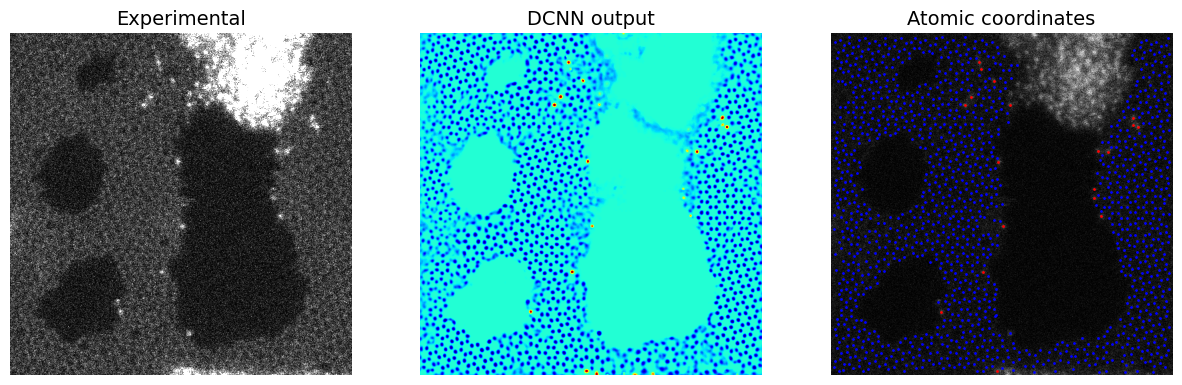

In [ ]:
#Visulaizing one frame of the data, we have 50 frames (0-49)

i = 49 # Choose movie frame

# Squeeze the channels in the predicted image (this is optional)
d_img = np.uint8(decoded_imgs[i]*255)
d_img = cv2.cvtColor(d_img, cv2.COLOR_BGR2GRAY)
# Get coordinates for C and Si atoms
lattice_coord_ = lattice_coord[i]
coord_Si = lattice_coord[i][np.where(lattice_coord[i][:,2]==1)][:,0:2]
coord_C = lattice_coord[i][np.where(lattice_coord[i][:,2]==0)][:,0:2]
# Plotting
fig = plt.figure(figsize = (15, 10), dpi = 100)
ax1 = fig.add_subplot(131)
ax1.imshow(STEM_real[i,:,:,0], vmin=0, vmax=0.3, cmap='gray')
ax1.axis('off')
ax1.set_title('Experimental', fontsize=14)
ax2 = fig.add_subplot(132)
ax2.imshow(d_img, cmap='jet', interpolation='Gaussian')
ax2.axis('off')
ax2.set_title('DCNN output', fontsize = 14)
ax3 = fig.add_subplot(133)
ax3.scatter(coord_Si[:,1], coord_Si[:,0], c='red', s=1)
ax3.scatter(coord_C[:,1], coord_C[:,0], c='blue', s=1)
ax3.imshow(STEM_real[i,:,:,0], cmap = 'gray')
ax3.axis('off')
ax3.set_title('Atomic coordinates', fontsize = 14)

In [ ]:
# Getting feature vectors
# Feature vectors here are the cropped images around the coordinates found by DCNN. The window_size of these cropped images can be changed below
window_size = 42
s = aoi.stat.imlocal(
    np.sum(decoded_imgs[..., :-1], -1)[..., None], # convert to a single channel (no background)
    lattice_coord,   # Coodinates array, acts as the mid-point of the cropped sub-images 
    window_size, 0)

imstack = tt(s.imgstack[:,None,:,:, 0])
frames_all = s.imgstack_frames # will need for plotting VAE results
com_all = s.imgstack_com # will need for plotting VAE results

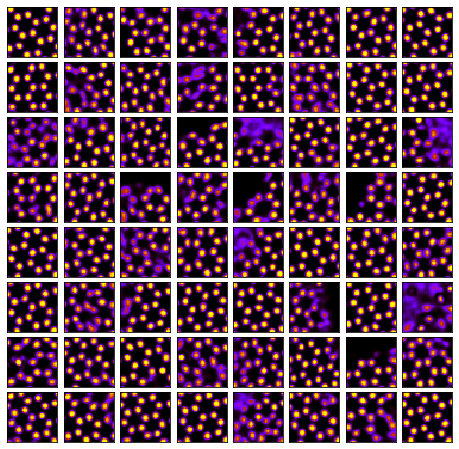

In [ ]:
# Visulaizing the training dataset
np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(imstack))
    ax.imshow(imstack[i, 0], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Training the rVAE on the subimages generated 
# The trained weights will be loaded in the next cell
# So, one can skip this cell to save sometime.

input_dim = (42,42)   # Input dimensions of the dataset i.e., shape of each card's image
jrvae_graphene_2cls = aoi.models.jrVAE(input_dim, latent_dim=2,   # Number of latent dimensions other than the invariancies
                          discrete_dim=[2],   # Number of discrete dimensions
                          numlayers_encoder=4,   # Number of hidden layers in the encoder
                          numhidden_encoder=1024,   # Number of neurons in each of the hidden layers in the encoder
                          numlayers_decoder=4,   # Number of hidden layers in the decoder
                          numhidden_decoder=1024,   # Number of neurons in each of the hidden layers in the decoder
                          skip=True, seed = 0)

# Fitting the model   
jrvae_graphene_2cls.fit(imstack[:, 0], training_cycles=200, batch_size=100, loss="ce", translation_prior=0.1, 
                   filename="jrvae_graphene_2cls")

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# Downloading the saved model
!gdown 1Lyk--R5xfk9-7FvaFliJ-YttzY6humwD

# Loading the saved model
jrvae_graphene_2cls = aoi.load_model('jrvae_graphene_2cls.tar')

Downloading...
From: https://drive.google.com/uc?id=1Lyk--R5xfk9-7FvaFliJ-YttzY6humwD
To: /content/jrvae_graphene_2cls.tar
100% 110M/110M [00:01<00:00, 60.3MB/s]


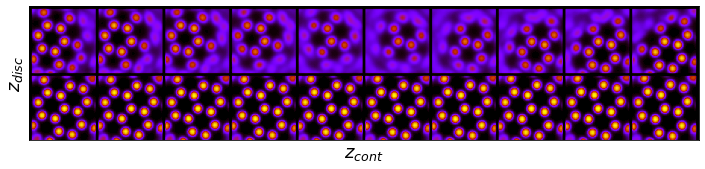

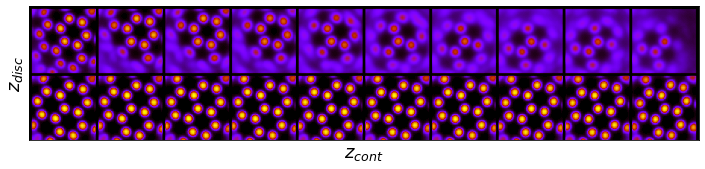

In [ ]:
# Traverse Manifolds

# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

# Traverse manifold is the decoded latent space in which one of the continouous latent dimension is held at constant (0),
# While the other continuous dimensions and the discrete dimension are used to plot the decoded latent space.
for i in range(2):
    jrvae_graphene_2cls.manifold_traversal(i, origin="upper")

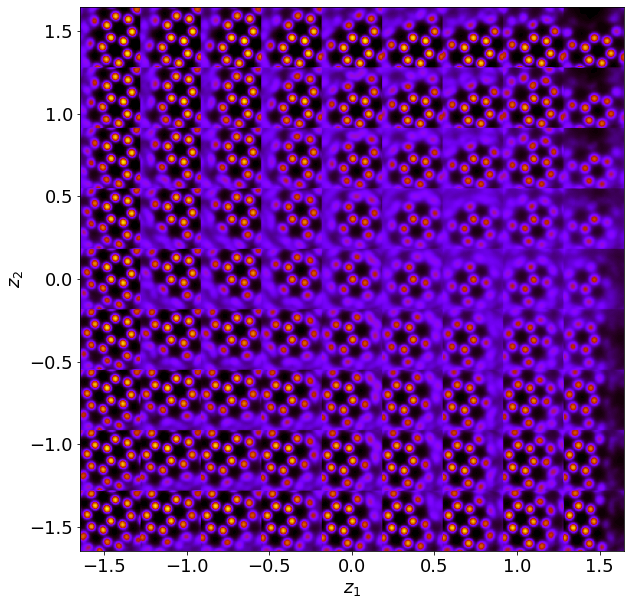

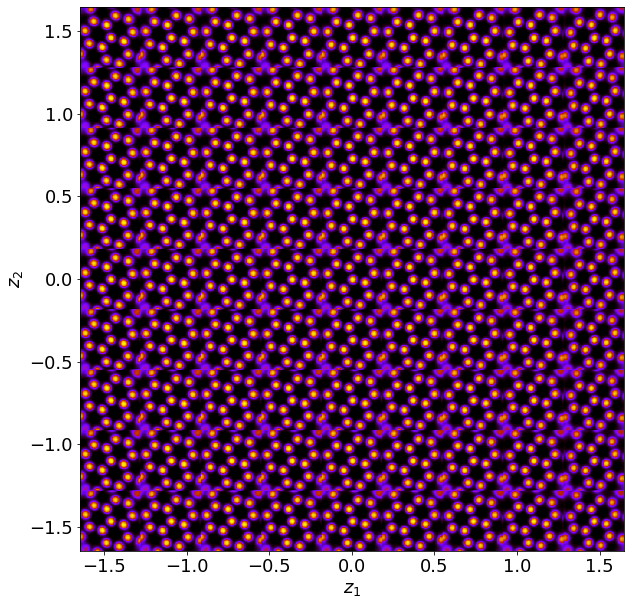

In [ ]:
# Decoded latent space of each class
for i in range(2):
    jrvae_graphene_2cls.manifold2d(d=9, disc_idx=i, origin="upper")

Latent Distributions:  
Input images are represented as points in the latent space using the encoder  
These points are then colored with various ground-truth properties to visualize their distribution 

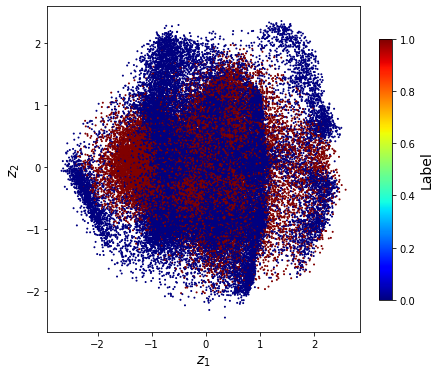

In [ ]:
z_mean2, z_sd2, alpha_all2 = jrvae_graphene_2cls.encode(imstack[:, 0])# Encoding the full input dataset
# z_mean2: mean of the latent space representation of the input dataset, 
# z_sd2: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions) 
# alpha_all2: corresponds to the encoding in the discrete dimension

# Latent distribution colored using the predicted class of each image
pred_class2 = np.argmax(alpha_all2, axis = 1)
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean2[:,-1], z_mean2[:,-2], s=1, c = pred_class2, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

In [ ]:
# (z1): corresponds to angle and 
# (z2): Corresponds to the translations
# (z3):  the regular latent dimensions 
z1, z2, z3 = z_mean2[:,0], z_mean2[:, 1:3], z_mean2[:, 3:]

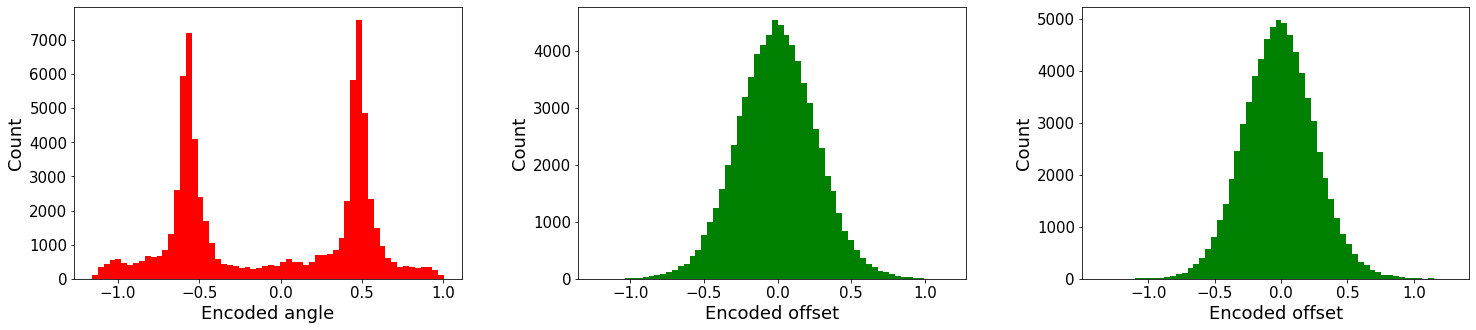

In [ ]:
# Histograms of the encoded angle and the translations

fig, ax = plt.subplots(1, 3, figsize=(25, 5))
ax[0].hist(z1, bins=60, color='red')
ax[1].hist(z2[:, 0], bins=60, color='green')
ax[2].hist(z2[:, 1], bins=60, color='green')
ax[0].set_xlabel("Encoded angle", fontsize=18)
ax[1].set_xlabel("Encoded offset", fontsize=18)
ax[2].set_xlabel("Encoded offset", fontsize=18)
for _ax in fig.axes:
    _ax.set_ylabel("Count", fontsize=18)
    _ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.3)

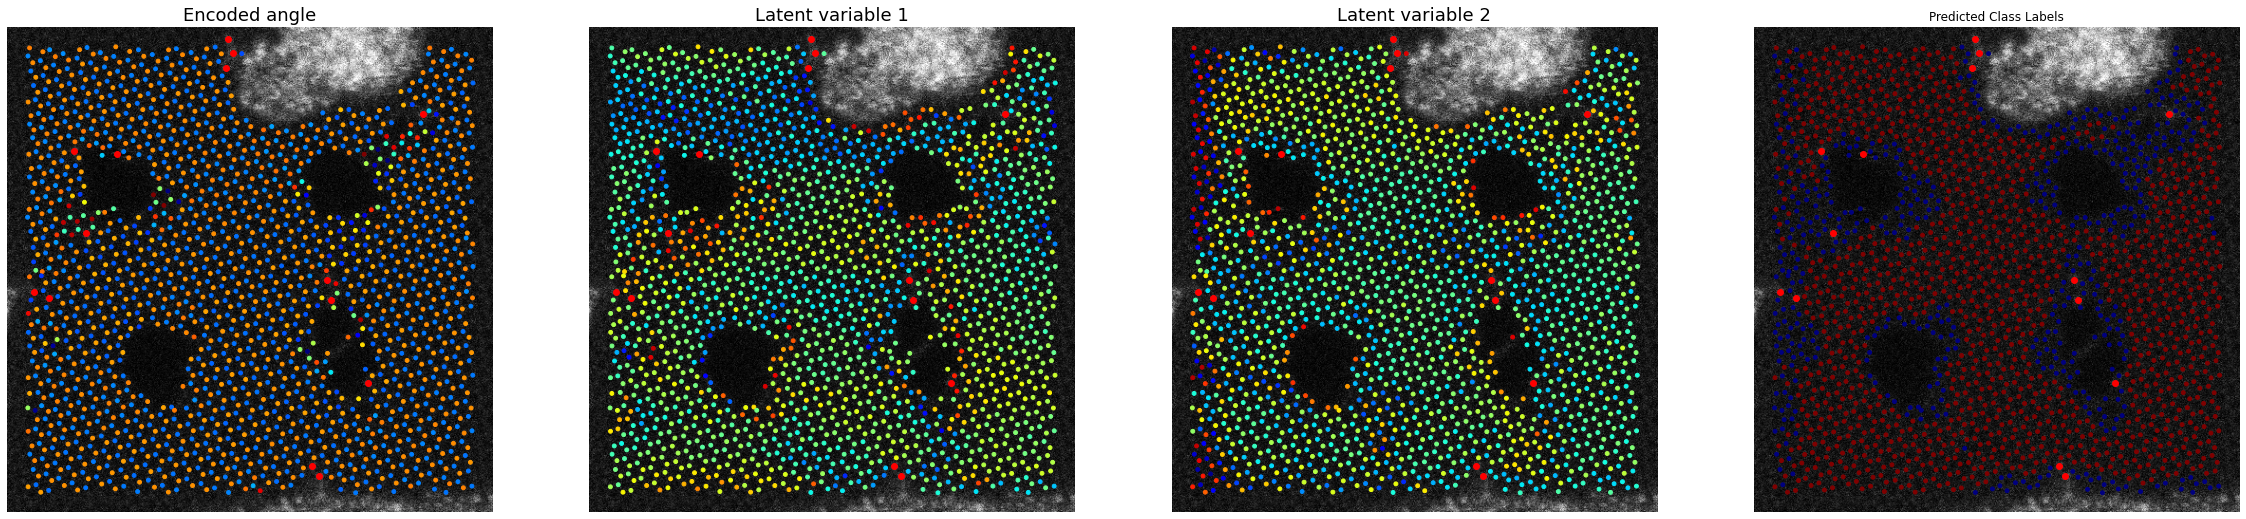

In [ ]:
# Plotting the latent variables in on the image data
#Visualizing the latent space encodings on the raw STEM image

frame = 0 # select frame
lab_i = pred_class2[frames_all == frame]
com_i = com_all[frames_all == frame] # get coordinates for this frame
com_i_Si = lattice_coord[frame] # get Si coordinates for plotting
com_i_Si = com_i_Si[com_i_Si[:,-1]==1.]
z1_i = z1[frames_all == frame] # get latent variables (image) for this frame
z3_i = z3[frames_all == frame] # get latent variables (image) for this frame

col_min0 = z1.min()
col_max0 = z1.max()
col_min1 = z3[:, 0].min()
col_max1 = z3[:, 0].max()
col_min2 = z3[:, 1].min()
col_max2 = z3[:, 1].max()

fig, ax = plt.subplots(1, 4, figsize=(40, 10))
ax[0].imshow(STEM_real[frame,...,0], cmap="gray")
ax[0].scatter(com_i[:, 1], com_i[:, 0], c=z1_i, s=15,
            cmap="jet")

ax[0].set_title("Encoded angle", fontsize=18)
ax[1].imshow(STEM_real[frame,...,0], cmap="gray")
ax[1].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 0], s=15,
            cmap="jet", vmin=col_min1, vmax=col_max1)
ax[1].set_title("Latent variable 1", fontsize=18)
ax[2].imshow(STEM_real[frame,...,0], cmap="gray")
ax[2].scatter(com_i[:, 1], com_i[:, 0], c=z3_i[:, 1], s=15,
              cmap="jet", vmin=col_min2, vmax=col_max2)
ax[2].set_title("Latent variable 2", fontsize=18)

ax[3].imshow(STEM_real[frame,...,0], cmap="gray")
ax[3].scatter(com_i[:, 1], com_i[:, 0], c=lab_i, s=15,
            cmap="jet")
ax[3].set_title('Predicted Class Labels')
for _ax in fig.axes:
    _ax.scatter(com_i_Si[:, 1], com_i_Si[:, 0], s=35, c='Red')
    _ax.axis(False)
plt.show()